<a href="https://colab.research.google.com/github/scottthomaswx/RadarHodographs/blob/main/RadarHodograph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Needed Packages

In [2]:
# @title
%%capture
!pip install matplotlib
!pip install numpy
!pip install arm-pyart
!pip install metpy
!pip install nexradaws
!pip install pytz
!pip install datetime

import matplotlib.pyplot as plt
from metpy.units import units
import pyart
import numpy as np
from metpy.plots import Hodograph
import nexradaws
import pytz
import metpy.calc as mpcalc
from datetime import datetime
import matplotlib.colors as colors

!mkdir radar_data
!mkdir cf_radial
!rm -rf sample_data

#Get Needed Parameters

In [69]:
timezone = pytz.timezone('UTC') #Note Format for US Timezones is 'US/Eastern', 'US/Central' etc...
radar_id = 'KGRR'
start = timezone.localize(datetime(2023,8,24,23,0))
end = timezone.localize(datetime(2023,8,25,2,0))
storm_motion_method = 'Bunkers Right' #Choose Mean Wind, Bunkers Left, Bunkers Right, User Selected, Corfidi Downshear, Corfidi Upshear
sm_dir = 999 #Enter 999 If Not Using
sm_speed = 999 #Enter 99 If Not Using
sfc_dir = 10
sfc_spd = 4

#Establish AWS Connection

In [21]:
# @title
conn = nexradaws.NexradAwsInterface()
scans = conn.get_avail_scans_in_range(start, end, radar_id)
print("There are {} scans available between {} and {}\n".format(len(scans), start, end))

There are 44 scans available between 2023-08-24 23:00:00+00:00 and 2023-08-25 02:00:00+00:00



#Download Radar Data

In [5]:
# @title
%%capture
results = conn.download(scans[0:], '/content/radar_data')

#Select file of choice from radar_data folder and copy path below

In [6]:
file = '/content/radar_data/KGRR20230825_002030_V06'

#Get Needed Strings and Get Radar File

In [7]:
# @title
%%capture

rad = file.split('/')[3]
time = rad.split('_')[1]
seg = rad.split('_')[0]
date = seg[4:]

n = 2

out = []
for i in range(0, len(time), n):
    out.append(time[i:i+n])

datearr = []
for i in range(0, len(date), n):
    datearr.append(date[i:i+n])

radar = pyart.io.read(file)
radar

# create a gate filter which specifies gates to exclude from dealiasing
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_invalid("velocity")
gatefilter.exclude_invalid("reflectivity")
gatefilter.exclude_outside("reflectivity", 0, 80)

# perform dealiasing
dealias_data = pyart.correct.dealias_region_based(radar, gatefilter=gatefilter)
radar.add_field("corrected_velocity", dealias_data)

pyart.io.write_cfradial(f'/content/cf_radial/{rad}.nc', radar, format='NETCDF4')

#Create Vertical Wind Profile and Convert to Knots

In [8]:
# @title
%%capture
ncrad = pyart.io.read_cfradial(f'/content/cf_radial/{rad}.nc')

# Loop on all sweeps and compute VAD
zlevels = np.arange(0, 9000, 100)  # height above radar
u_allsweeps = []
v_allsweeps = []

for idx in range(ncrad.nsweeps):
    radar_1sweep = ncrad.extract_sweeps([idx])
    vad = pyart.retrieve.vad_browning(
        radar_1sweep, "corrected_velocity", z_want=zlevels
    )
    u_allsweeps.append(vad.u_wind)
    v_allsweeps.append(vad.v_wind)

# Average U and V over all sweeps and compute magnitude and angle
u_avg = np.nanmean(np.array(u_allsweeps), axis=0)
v_avg = np.nanmean(np.array(v_allsweeps), axis=0)
orientation = np.rad2deg(np.arctan2(-u_avg, -v_avg)) % 360
speed = np.sqrt(u_avg**2 + v_avg**2)
u_avg *= 1.944
v_avg *= 1.944

#Calculate Shear and SRM



In [110]:
# @title
def calc_components(speed, direction):
  u_comp = speed * np.cos(np.deg2rad(direction))
  v_comp = speed * np.sin(np.deg2rad(direction))
  return u_comp, v_comp

def calc_vector(u_comp, v_comp):
  mag = np.sqrt(u_comp**2 + v_comp**2)
  dir = np.rad2deg(np.arctan2(u_comp, v_comp)) % 360
  return mag, dir

def calc_shear(u_layer, v_layer, height, zlevels):
  layer_top = np.where(zlevels == (height*1000))[0][0]
  u_shr = u_layer[layer_top] - u_layer[0]
  v_shr = v_layer[layer_top] - v_layer[0]
  shrmag = np.hypot(u_shr, v_shr)
  return shrmag

def calc_motion(u_layer, v_layer, zlevels):
  layer_top = np.where(zlevels == (6000))[0][0]
  mean_u = np.mean(u_layer[:layer_top])
  mean_v = np.mean(v_layer[:layer_top])
  return mean_u, mean_v

def calc_bunkers(u_layer, v_layer, zlevels):
  layer_top = np.where(zlevels == (6000))[0][0]
  mean_u = np.mean(u_layer[:layer_top])
  mean_v = np.mean(v_layer[:layer_top])

  layer_top = np.where(zlevels == (6000))[0][0]
  u_shr = u_layer[layer_top] - u_layer[0]
  v_shr = v_layer[layer_top] - v_layer[0]

  dev = 7.5 * 1.94

  dev_amnt = dev / np.hypot(u_shr, v_shr)
  rstu = mean_u + (dev_amnt * v_shr)
  rstv = mean_v - (dev_amnt * u_shr)
  lstu = mean_u - (dev_amnt * v_shr)
  lstv = mean_v + (dev_amnt * u_shr)
  rmag, rdir = calc_vector(rstu, rstv)
  lmag, ldir = calc_vector(lstu, lstv)

  return rstu, rstv, lstu, lstv, rmag, rdir, lmag, ldir

def calc_corfidi(u_layer, v_layer, zlevels, u_mean, v_mean):
  llj_top = np.where(zlevels == (1500))[0][0]
  llj_u = u_layer[:llj_top]
  llj_v = v_layer[:llj_top]

  mag, dir = calc_vector(llj_u, llj_v)
  max=0
  i=0
  for a in mag:
    if mag[i] >= mag[i-1]:
      max = i

  u_max = llj_u[i]
  v_max = llj_v[i]

  corfidi_up_u = u_mean - u_max
  corfidi_up_v =  v_mean - v_max

  corfidi_down_u = u_mean + corfidi_up_u
  corfidi_down_v = v_mean + corfidi_up_v

  return corfidi_up_u, corfidi_up_v, corfidi_down_u, corfidi_down_v

shr005 = calc_shear(u_avg, v_avg, 0.5, zlevels)
shr01 = calc_shear(u_avg, v_avg, 1, zlevels)
shr03 = calc_shear(u_avg, v_avg, 3, zlevels)
shr06 = calc_shear(u_avg, v_avg, 6, zlevels)
shr08 = calc_shear(u_avg, v_avg, 8, zlevels)

u_mean, v_mean = calc_motion(u_avg, v_avg, zlevels)
mean_mag, mean_dir = calc_vector(u_mean, v_mean)
rmu, rmv, lmu, lmv, rmag, rdir, lmag, ldir = calc_bunkers(u_avg, v_avg, zlevels)
cvu_u, cvu_v, cvd_u, cvd_v = calc_corfidi(u_avg, v_avg, zlevels, u_mean, v_mean)

cor_u_mag, cor_u_dir = calc_vector(cvu_u, cvu_v)
cor_d_mag, cor_d_dir = calc_vector(cvd_u, cvd_v)

def conv_angle(mean_dir, rdir, ldir, sfc_dir, cor_u_dir, cor_d_dir):
  meanang = 270-mean_dir
  meanang +=180
  if meanang < 0:
    meanang += 360

  rang = 270-rdir
  rang +=180
  if rang < 0:
    rang += 360

  lang = 270-ldir
  lang +=180
  if lang < 0:
    lang += 360

  sfcang = 270 - sfc_dir
  if sfcang < 0:
    sfcang += 360

  downdir = 270-cor_d_dir
  downdir +=180
  if downdir < 0:
    downdir += 360

  updir = 270-cor_u_dir
  updir +=180
  if updir < 0:
    updir += 360

  return meanang, rang, lang, sfcang, downdir, updir

mean_dirmet, rang, lang, sfc_angle, down_adj, up_adj = conv_angle(mean_dir, rdir, ldir, sfc_dir, cor_u_dir, cor_d_dir)
sfc_u, sfc_v = calc_components(sfc_spd, sfc_angle)

if sm_dir != 999:
  u_sm, v_sm = calc_components(sm_speed, sm_dir)

if storm_motion_method == 'Mean Wind':
  sr_u = u_avg - u_mean
  sr_v = v_avg - v_mean
  sr_mw_u = u_mean - u_mean
  sr_br_u = rmu - u_mean
  sr_bl_u = lmu - u_mean
  sr_mw_v = v_mean - v_mean
  sr_br_v = rmv - v_mean
  sr_bl_v = lmv - v_mean
  sr_sfc_u = sfc_u - u_mean
  sr_sfc_v = sfc_v - v_mean
  sr_cu_u =  cvu_u - u_mean
  sr_cd_u = cvd_u - u_mean
  sr_cu_v = cvu_v - v_mean
  sr_cd_v = cvd_v - v_mean
if storm_motion_method == 'User Selected':
  sr_u = u_avg - u_sm
  sr_v = v_avg - v_sm
  sr_mw_u = u_mean - u_sm
  sr_br_u = rmu - u_sm
  sr_bl_u = lmu - u_sm
  sr_mw_v = v_mean - v_sm
  sr_br_v = rmv - v_sm
  sr_bl_v = lmv - v_sm
  sr_sfc_u = sfc_u - u_sm
  sr_sfc_v = sfc_v - v_sm
  sr_cu_u =  cvu_u - u_sm
  sr_cd_u = cvd_u - u_sm
  sr_cu_v = cvu_v - v_sm
  sr_cd_v = cvd_v - v_sm
if storm_motion_method == 'Bunkers Right':
  sr_u = u_avg - rmu
  sr_v = v_avg - rmv
  sr_mw_u = u_mean - rmu
  sr_br_u = rmu - rmu
  sr_bl_u = lmu - rmu
  sr_mw_v = v_mean - rmv
  sr_br_v = rmv - rmv
  sr_bl_v = lmv - rmv
  sr_sfc_u = sfc_u - rmu
  sr_sfc_v = sfc_v - rmv
  sr_cu_u =  cvu_u - rmu
  sr_cd_u = cvd_u - rmu
  sr_cu_v = cvu_v - rmv
  sr_cd_v = cvd_v - rmv
if storm_motion_method == 'Bunkers Left':
  sr_u = u_avg - lmu
  sr_v = v_avg - lmv
  sr_mw_u = u_mean - lmu
  sr_br_u = rmu - lmu
  sr_bl_u = lmu - lmu
  sr_mw_v = v_mean - lmv
  sr_br_v = rmv - lmv
  sr_bl_v = lmv - lmv
  sr_sfc_u = sfc_u - lmu
  sr_sfc_v = sfc_v - lmv
  sr_cu_u =  cvu_u - lmu
  sr_cd_u = cvd_u - lmu
  sr_cu_v = cvu_v - lmv
  sr_cd_v = cvd_v - lmv

if storm_motion_method == 'Corfidi Downshear':
  sr_u = u_avg - cvd_u
  sr_v = v_avg - cvd_v
  sr_mw_u = u_mean - cvd_u
  sr_br_u = rmu - cvd_u
  sr_bl_u = lmu - cvd_u
  sr_mw_v = v_mean - cvd_v
  sr_br_v = rmv - cvd_v
  sr_bl_v = lmv - cvd_v
  sr_sfc_u = sfc_u - cvd_u
  sr_sfc_v = sfc_v - cvd_v
  sr_cu_u =  cvu_u - cvd_u
  sr_cd_u = cvd_u - cvd_u
  sr_cu_v = cvu_v - cvd_v
  sr_cd_v = cvd_v - cvd_v

if storm_motion_method == 'Corfidi Upshear':
  sr_u = u_avg - cvu_u
  sr_v = v_avg - cvu_v
  sr_mw_u = u_mean - cvu_u
  sr_br_u = rmu - cvu_u
  sr_bl_u = lmu - cvu_u
  sr_mw_v = v_mean - cvu_v
  sr_br_v = rmv - cvu_v
  sr_bl_v = lmv - cvu_v
  sr_sfc_u = sfc_u - cvu_u
  sr_sfc_v = sfc_v - cvu_v
  sr_cu_u =  cvu_u - cvu_u
  sr_cd_u = cvd_u - cvu_u
  sr_cu_v = cvu_v - cvu_v
  sr_cd_v = cvd_v - cvu_v

#Plot Base Hodograph

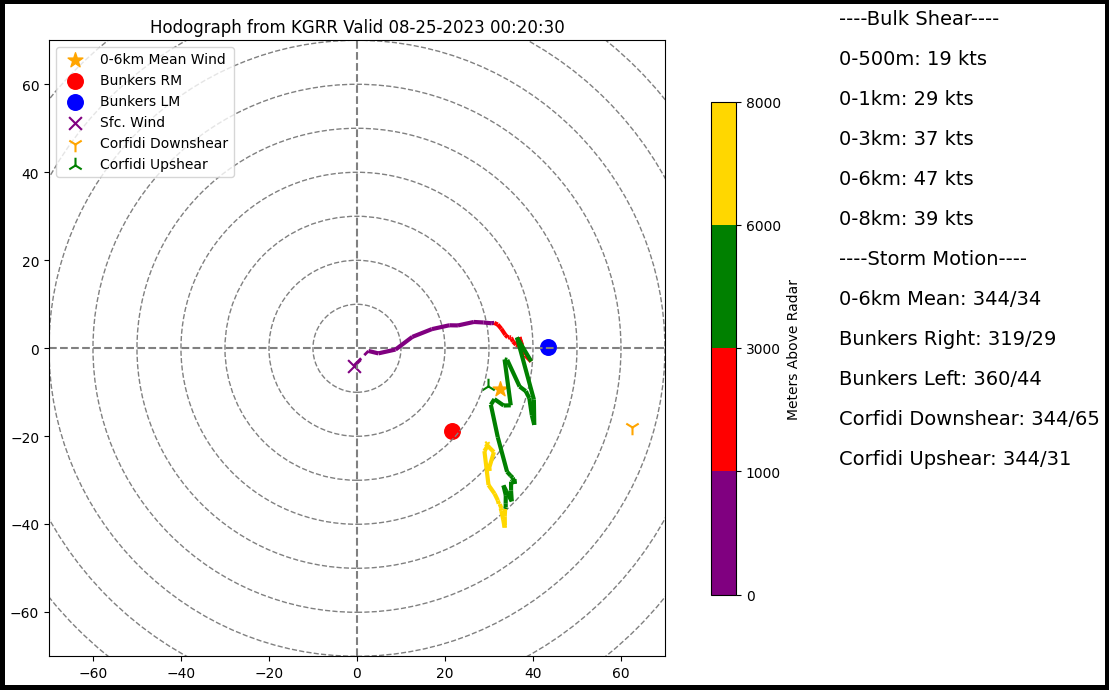

In [111]:
#Create Figure
fig = plt.figure(figsize=(12,8), facecolor='white', edgecolor="black", linewidth = 6)
ax=fig.add_subplot(1,1,1)
h = Hodograph(ax, component_range = 70)
h.add_grid(increment = 10)

#Create Colormap
boundaries = np.array([0,1000,3000,6000,8000])
colors = ['purple', 'red', 'green', 'gold']

#Plot Hodograph and Winds
l = h.plot_colormapped(u_avg, v_avg, zlevels, intervals = boundaries, colors = colors)
mw = ax.scatter(u_mean, v_mean, color = 'orange', marker = '*', label = '0-6km Mean Wind', s = 125)
rm = ax.scatter(rmu, rmv, color = 'red', marker = 'o', label = 'Bunkers RM', s = 125)
lm = ax.scatter(lmu, lmv, color = 'blue', marker = 'o', label = 'Bunkers LM', s = 125)
sfc = ax.scatter(sfc_u, sfc_v, color = 'purple', marker = 'x', s = 85, label = 'Sfc. Wind')
cd = ax.scatter(cvd_u, cvd_v, color = 'orange', marker = '1', s = 125, label = 'Corfidi Downshear')
cu = ax.scatter(cvu_u, cvu_v, color = 'green', marker = '2', s = 125, label = 'Corfidi Upshear')
plt.plot([sfc_u, u_avg[0]], [sfc_v, v_avg[0]], color="purple", linestyle = '--', linewidth = 2)
if sm_dir != 999:
  us = ax.scatter(u_sm, v_sm, color = 'black', marker = 'x', label = 'User Selected', s = 125)

#Add Colorbar and Fig Text
CS = plt.colorbar(l, shrink=0.8)
CS.set_label('Meters Above Radar')
plt.figtext(0.89,0.90, "----Bulk Shear----  ", fontsize = 14)
plt.figtext(0.89,0.85, f"0-500m: {'{:.0f}'.format(shr005)} kts", fontsize = 14)
plt.figtext(0.89,0.80, f"0-1km: {'{:.0f}'.format(shr01)} kts", fontsize = 14)
plt.figtext(0.89,0.75, f"0-3km: {'{:.0f}'.format(shr03)} kts", fontsize = 14)
plt.figtext(0.89,0.70, f"0-6km: {'{:.0f}'.format(shr06)} kts", fontsize = 14)
plt.figtext(0.89,0.65, f"0-8km: {'{:.0f}'.format(shr08)} kts", fontsize = 14)
plt.figtext(0.89,0.60, "----Storm Motion----  ", fontsize = 14)
plt.figtext(0.89,0.55, f"0-6km Mean: {'{:.0f}'.format(mean_dirmet)}/{'{:.0f}'.format(mean_mag)}", fontsize = 14)
plt.figtext(0.89,0.50, f"Bunkers Right: {'{:.0f}'.format(rang)}/{'{:.0f}'.format(rmag)}", fontsize = 14)
plt.figtext(0.89,0.45, f"Bunkers Left: {'{:.0f}'.format(lang)}/{'{:.0f}'.format(lmag)}", fontsize = 14)
plt.figtext(0.89,0.40, f"Corfidi Downshear: {'{:.0f}'.format(down_adj)}/{'{:.0f}'.format(cor_d_mag)}", fontsize = 14)
plt.figtext(0.89,0.35, f"Corfidi Upshear: {'{:.0f}'.format(up_adj)}/{'{:.0f}'.format(cor_u_mag)}", fontsize = 14)

#Add Title and Legend and Save Figure
plt.title(f'Hodograph from {radar_id} Valid {datearr[2]}-{datearr[3]}-{datearr[0]}{datearr[1]} {out[0]}:{out[1]}:{out[2]}')
plt.legend(loc = 'upper left')
plt.savefig(f'Hodograph_{radar_id}_{date}_{time}', bbox_inches='tight')

#Storm Relative Hodograph

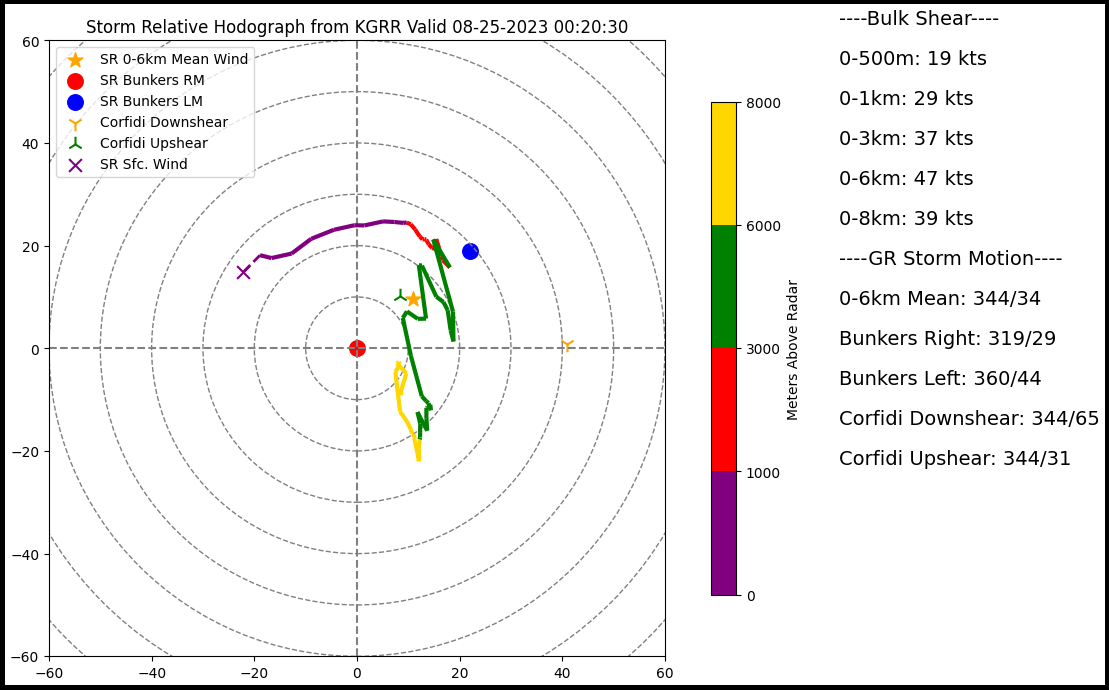

In [112]:
#Create Figure
fig = plt.figure(figsize=(12,8), facecolor='white', edgecolor="black", linewidth = 6)
ax=fig.add_subplot(1,1,1)
h = Hodograph(ax, component_range = 60)
h.add_grid(increment = 10)

#Create Colormap
boundaries = np.array([0,1000,3000,6000,8000])
colors = ['purple', 'red', 'green', 'gold']

#Plot Hodograph and Winds
l = h.plot_colormapped(sr_u, sr_v, zlevels, intervals = boundaries, colors = colors)
mw = ax.scatter(sr_mw_u, sr_mw_v, color = 'orange', marker = '*', label = 'SR 0-6km Mean Wind', s = 125)
rm = ax.scatter(sr_br_u, sr_br_v, color = 'red', marker = 'o', label = 'SR Bunkers RM', s = 125)
lm = ax.scatter(sr_bl_u, sr_bl_v, color = 'blue', marker = 'o', label = 'SR Bunkers LM', s = 125)
cd = ax.scatter(sr_cd_u, sr_cd_v, color = 'orange', marker = '1', s = 125, label = 'Corfidi Downshear')
cu = ax.scatter(sr_cu_u, sr_cu_v, color = 'green', marker = '2', s = 125, label = 'Corfidi Upshear')
sfc = ax.scatter(sr_sfc_u, sr_sfc_v, color = 'purple', marker = 'x', s = 85, label = 'SR Sfc. Wind')
plt.plot([sr_sfc_u, sr_u[0]], [sr_sfc_v, sr_v[0]], color="purple", linestyle = '--', linewidth = 2)
if sm_dir != 999:
  us = ax.scatter(u_sm, v_sm, color = 'black', marker = 'x', label = 'User Selected', s = 125)

#Add Colorbar and Fig Text
CS = plt.colorbar(l, shrink=0.8)
CS.set_label('Meters Above Radar')

plt.figtext(0.89,0.90, "----Bulk Shear----  ", fontsize = 14)
plt.figtext(0.89,0.85, f"0-500m: {'{:.0f}'.format(shr005)} kts", fontsize = 14)
plt.figtext(0.89,0.80, f"0-1km: {'{:.0f}'.format(shr01)} kts", fontsize = 14)
plt.figtext(0.89,0.75, f"0-3km: {'{:.0f}'.format(shr03)} kts", fontsize = 14)
plt.figtext(0.89,0.70, f"0-6km: {'{:.0f}'.format(shr06)} kts", fontsize = 14)
plt.figtext(0.89,0.65, f"0-8km: {'{:.0f}'.format(shr08)} kts", fontsize = 14)

plt.figtext(0.89,0.60, "----GR Storm Motion----  ", fontsize = 14)
plt.figtext(0.89,0.55, f"0-6km Mean: {'{:.0f}'.format(mean_dirmet)}/{'{:.0f}'.format(mean_mag)}", fontsize = 14)
plt.figtext(0.89,0.50, f"Bunkers Right: {'{:.0f}'.format(rang)}/{'{:.0f}'.format(rmag)}", fontsize = 14)
plt.figtext(0.89,0.45, f"Bunkers Left: {'{:.0f}'.format(lang)}/{'{:.0f}'.format(lmag)}", fontsize = 14)
plt.figtext(0.89,0.40, f"Corfidi Downshear: {'{:.0f}'.format(down_adj)}/{'{:.0f}'.format(cor_d_mag)}", fontsize = 14)
plt.figtext(0.89,0.35, f"Corfidi Upshear: {'{:.0f}'.format(up_adj)}/{'{:.0f}'.format(cor_u_mag)}", fontsize = 14)

#Add Title and Legend and Save Figure
plt.title(f'Storm Relative Hodograph from {radar_id} Valid {datearr[2]}-{datearr[3]}-{datearr[0]}{datearr[1]} {out[0]}:{out[1]}:{out[2]}')
plt.legend(loc = 'upper left')
plt.savefig(f'SR_Hodograph_{radar_id}_{date}_{time}', bbox_inches='tight')

In [64]:
[u_avg[0], v_avg[0]]

[2.607397187990751, -0.6120484178750444]